In [15]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import os

In [16]:
df = pd.read_csv('T1.csv', delimiter=',')

In [46]:
dataset = df[['Date/Time','Wind Direction (°)']]
dataset = dataset.rename(columns = {"Date/Time" :"timeStamp","Wind Direction (°)":"windDirection"})
dataset = dataset[5000:8000]

In [47]:
newTime = []
for i in dataset['timeStamp']:
    # YYYY-MM-DD HH:MM:SS   => Required
    # DD MM YYYY HH:MM      => my format
    #print("{0}-{1}-{2} {3}:00".format(i[6:10],i[3:5],i[:2],i[11:16]))
    newTime.append(i[6:10] + "-" + i[3:5] + "-" + i[:2] + " " + i[11:16] + ":00")
dataset['timeStamp'] = newTime

,windDirection
timeStamp,
2018-02-09 05:10:00,212.558395
2018-02-09 05:20:00,218.988907
2018-02-09 05:30:00,217.286697
2018-02-09 05:40:00,220.837708
2018-02-09 05:50:00,225.290802
...,...
2018-03-02 00:20:00,202.606903
2018-03-02 00:30:00,200.007904
2018-03-02 00:40:00,200.687805


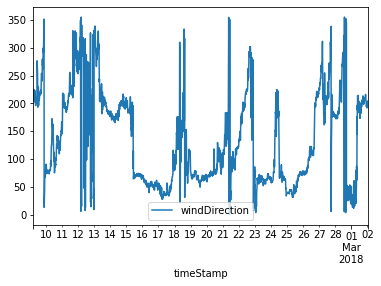

In [48]:
dataset.index = pd.to_datetime(dataset.timeStamp)
# dataset.index = pd.DatetimeIndex(dataset.index).to_period('H')
# dataset.index = pd.DatetimeIndex(dataset.index)
dataset = dataset.drop('timeStamp', axis=1)

dataset.plot()

dataset = dataset.sort_index()
dataset.fillna(df.mean(numeric_only=True))

In [49]:
# Testing whether there are null values
dataset[dataset.isnull()]
len(dataset[dataset.isnull()])
dataset = dataset.sort_index()
dataset.index

DatetimeIndex(['2018-02-09 05:10:00', '2018-02-09 05:20:00',
               '2018-02-09 05:30:00', '2018-02-09 05:40:00',
               '2018-02-09 05:50:00', '2018-02-09 06:00:00',
               '2018-02-09 06:10:00', '2018-02-09 06:20:00',
               '2018-02-09 06:30:00', '2018-02-09 06:40:00',
               ...
               '2018-03-01 23:30:00', '2018-03-01 23:40:00',
               '2018-03-01 23:50:00', '2018-03-02 00:00:00',
               '2018-03-02 00:10:00', '2018-03-02 00:20:00',
               '2018-03-02 00:30:00', '2018-03-02 00:40:00',
               '2018-03-02 00:50:00', '2018-03-02 01:00:00'],
              dtype='datetime64[ns]', name='timeStamp', length=3000, freq=None)

In [50]:
# Replacing NaN values with the previous effective data
dataset.windDirection.fillna(method='pad', inplace=True)
dataset[dataset.windDirection.isnull()]

dataset.describe()

,windDirection
count,3000.000000
mean,134.921301
std,80.474205
min,0.218672
25%,66.365105
50%,114.994701
75%,200.378448
max,355.202911


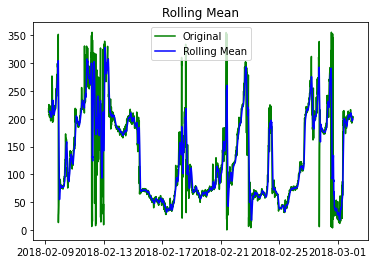

Augmented Dickey-Fuller test:
type of df_test:  <class 'tuple'>
df_test:  (-4.257019703867187, 0.0005268200477753433, 11, 2988, {'1%': -3.432540403849221, '5%': -2.862507778275112, '10%': -2.5672851740608125}, 28732.703226480862)
df_output: 
 Test Statistic                   -4.257020
p-value                           0.000527
#Lags Used                       11.000000
Number of Observations Used    2988.000000
dtype: float64
Test Statistic                   -4.257020
p-value                           0.000527
#Lags Used                       11.000000
Number of Observations Used    2988.000000
Critical Value (1%)              -3.432540
Critical Value (5%)              -2.862508
Critical Value (10%)             -2.567285
dtype: float64


In [51]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(ts):    
    # Determing rolling statistics
    #roll_mean = pd.rolling_mean(ts, window=12)
    roll_mean = ts.rolling(12).mean()
    
    # Plot rolling statistics:
    plt.plot(ts, color='green',label='Original')
    plt.plot(roll_mean, color='blue', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print('Augmented Dickey-Fuller test:')
    df_test = adfuller(ts)
    print("type of df_test: ",type(df_test))
    print("df_test: ",df_test)
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print("df_output: \n",df_output)
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    print(df_output)
    
stationarity_check(dataset.windDirection)

In [52]:
#dfIndia['Roll_Mean'] = pd.rolling_mean(dfIndia.AverageTemperature, window=12)
dataset['Roll_Mean'] = dataset.windDirection.rolling(12).mean()
dataset.windDirection.rolling(12)

Rolling [window=12,center=False,axis=0,method=single]

C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


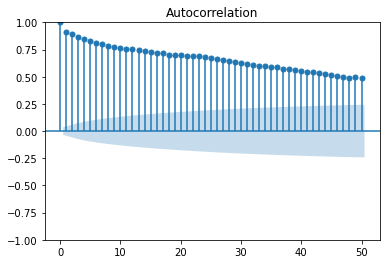

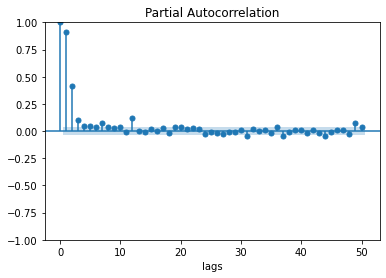

In [53]:
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
plot_acf(dataset.windDirection, lags=50)
plot_pacf(dataset.windDirection, lags=50)
plt.xlabel('lags')
plt.show()

In [54]:
import statsmodels.api as sm

import itertools
p = q = range(0, 4)
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = sm.tsa.arima.ARIMA(dataset.windDirection,order=(param[0], 0, param[1]))
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(0, 0) - AIC:34844.25181467514


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(0, 1) - AIC:32740.559675582124


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(0, 2) - AIC:31517.33458271275


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(0, 3) - AIC:30855.529531578624


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(1, 0) - AIC:29650.654041567366


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(1, 1) - AIC:29072.499302595097


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(1, 2) - AIC:29064.583427259953


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(1, 3) - AIC:29042.286098654324


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(2, 0) - AIC:29094.271280193796


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(2, 1) - AIC:29059.52964274263


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(2, 2) - AIC:29057.47809991535


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(2, 3) - AIC:29015.43106001582


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(3, 0) - AIC:29067.58916127504


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(3, 1) - AIC:29017.015308118745


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


ARMA(3, 2) - AIC:29017.772919387124


C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA pa

ARMA(3, 3) - AIC:29045.529645745333


In [67]:
model = sm.tsa.arima.ARIMA(dataset.windDirection, order=(1,0,2))  
results_MA = model.fit()  

C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\ujjwa\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)


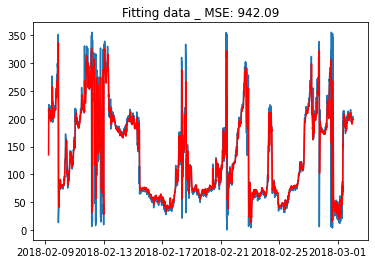

In [68]:
plt.plot(dataset.windDirection)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('Fitting data _ MSE: %.2f'% (((results_MA.fittedvalues-dataset.windDirection)**2).mean()))
plt.show()

In [70]:
dataset.index.is_unique
predictions = results_MA.predict('2018-12-01 18:50:00')
predictions
# predictions.plot()

2018-12-01 18:50:00    134.923122
Freq: 10T, dtype: float64

In [59]:
import joblib 
joblib.dump(results_MA, 'humidityModel.pkl') 

['humidityModel.pkl']